# SOURCE BASED FAKE NEWS CLASSIFICATION

In [20]:
## Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import plotly.express as px
import plotly
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier



In [21]:
!pip install wordcloud
import warnings
warnings.filterwarnings("ignore")

In [22]:
from wordcloud import WordCloud

In [23]:
import os

In [24]:
cwd = os.getcwd()
print(f"Current Working Directory: {cwd}")

Current Working Directory: /kaggle/working


## Step 1: Load the dataset

In [25]:
df = pd.read_csv('/kaggle/input/news-articles-data/news_articles.csv')
print(df.shape)
df.head()


(2096, 12)


,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
0,Barracuda Brigade,2016-10-26T21:41:00.000+03:00,muslims busted they stole millions in govt ben...,print they should pay all the back all the mon...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,muslims busted stole millions govt benefits,print pay back money plus interest entire fami...,1.0
1,reasoning with facts,2016-10-29T08:47:11.259+03:00,re why did attorney general loretta lynch plea...,why did attorney general loretta lynch plead t...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,attorney general loretta lynch plead fifth,attorney general loretta lynch plead fifth bar...,1.0
2,Barracuda Brigade,2016-10-31T01:41:49.479+02:00,breaking weiner cooperating with fbi on hillar...,red state \nfox news sunday reported this mor...,english,100percentfedup.com,http://bb4sp.com/wp-content/uploads/2016/10/Fu...,bias,Real,breaking weiner cooperating fbi hillary email ...,red state fox news sunday reported morning ant...,1.0
3,Fed Up,2016-11-01T05:22:00.000+02:00,pin drop speech by father of daughter kidnappe...,email kayla mueller was a prisoner and torture...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,pin drop speech father daughter kidnapped kill...,email kayla mueller prisoner tortured isis cha...,1.0
4,Fed Up,2016-11-01T21:56:00.000+02:00,fantastic trumps point plan to reform healthc...,email healthcare reform to make america great ...,english,100percentfedup.com,http://100percentfedup.com/wp-content/uploads/...,bias,Real,fantastic trumps point plan reform healthcare ...,email healthcare reform make america great sin...,1.0


## Step 2: Data Exploration and Preprocessing

In [26]:
df.isnull().sum()

author                      0
published                   0
title                       0
text                       46
language                    1
site_url                    1
main_img_url                1
type                        1
label                       1
title_without_stopwords     2
text_without_stopwords     50
hasImage                    1
dtype: int64

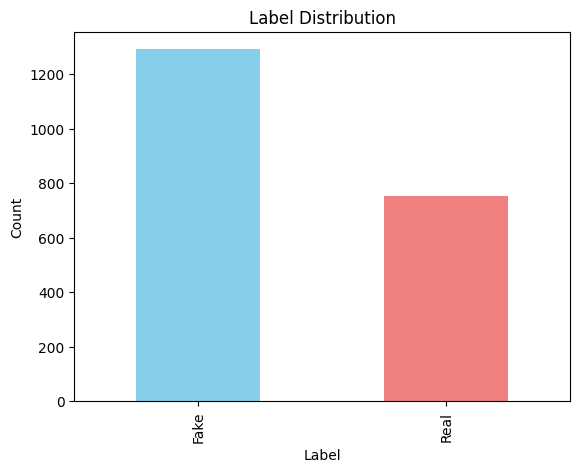

In [27]:
df= df.dropna()
label_distribution = df['label'].value_counts()
label_distribution.plot(kind='bar', color=['skyblue', 'lightcoral'])
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

## Step 3: Split the dataset into training and testing sets

In [28]:
df1 = df.sample(frac=1)
df1.head()

,author,published,title,text,language,site_url,main_img_url,type,label,title_without_stopwords,text_without_stopwords,hasImage
1012,Martist,2016-10-28T15:53:00.520+03:00,mike pence says shalom to israels republicans,published on jun by the rays of reason mill...,english,fromthetrenchesworldreport.com,http://www.fromthetrenchesworldreport.com/wp-c...,bs,Fake,fdny rope rescue manhattan thalarm,posted october joe massprivatei streamed live ...,1.0
474,Alex Ansary,2016-11-07T20:01:08.529+02:00,trump breaks from stump speech to admire beaut...,kremlin nato was created for agression \nruss...,english,amtvmedia.com,http://www.amtvmedia.com/wp-content/uploads/20...,bs,Fake,trump breaks stump speech admire beautiful tru...,kremlin nato created agression russia today re...,1.0
818,Dr. Patrick Slattery,2016-10-27T19:13:31.635+03:00,dr duke and dr macdonald call for prosecution ...,how they could steal the election from trump e...,english,davidduke.com,https://s0.wp.com/i/blank.jpg,hate,Real,dr duke dr macdonald call prosecution hillary ...,could steal election trump even announced winn...,1.0
65,Anonymous,2016-10-26T22:07:00.000+03:00,no title,there is plenty of proof the machines are rigg...,english,abeldanger.net,No Image URL,bs,Fake,title,plenty proof machines rigged whic also means t...,0.0
1443,Hrafnkell Haraldsson,2016-10-29T16:02:00.803+03:00,fox news calls for special prosecutor to inves...,by hrafnkell haraldsson pm were not concedi...,english,politicususa.com,http://15130-presscdn-0-89.pagely.netdna-cdn.c...,bias,Real,comey letter backfires email scandal revival e...,jason easley tue nov st pm republicans far rem...,1.0


In [29]:
y = df1.type

x = df1.loc[:,['site_url','text_without_stopwords']]
x['source'] = x["site_url"].astype(str) +" "+ x["text_without_stopwords"] 
x = x.drop(['site_url','text_without_stopwords'],axis=1)
x = x.source

In [30]:
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

## Step 4: Text Vectorization using TF-IDF

In [31]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [32]:
X_train_tfidf.shape

(1636, 5000)

In [33]:
X_test_tfidf.shape

(409, 5000)

## Step 5: Train a linear SVM classifier

In [34]:
svm_classifier = LinearSVC()
svm_classifier.fit(X_train_tfidf, y_train)

LinearSVC()

In [35]:
predictions = svm_classifier.predict(X_test_tfidf)


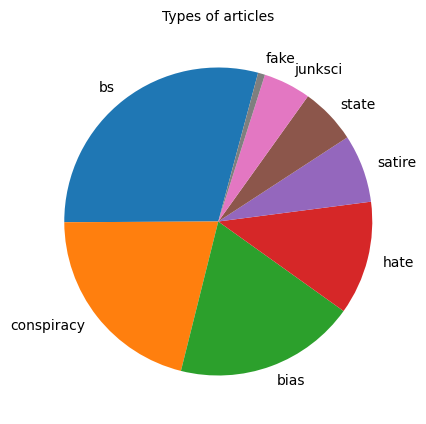

In [36]:
#real vs fake
fig = px.pie(df,names='label',title='Proportion of Real vs. Fake News')
df['type'].value_counts().plot.pie(figsize = (5,5), startangle = 75)
plt.title('Types of articles', fontsize = 10)
plt.axis('off')
plt.show()
fig.show()

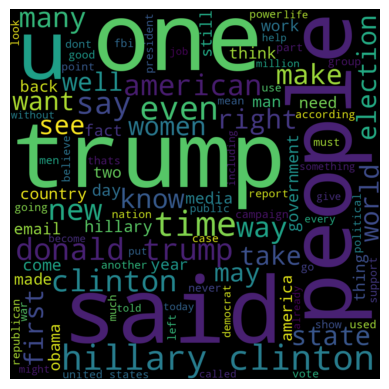

In [37]:
wc = WordCloud(background_color="black", max_words=100,
               max_font_size=256,
               random_state=42, width=1000, height=1000)
wc.generate(' '.join(df['text_without_stopwords']))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()


## Step 6: Evaluate the model

In [38]:
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

Accuracy: 0.79
Classification Report:
               precision    recall  f1-score   support

        Fake       0.82      0.88      0.85       264
        Real       0.74      0.65      0.69       145

    accuracy                           0.79       409
   macro avg       0.78      0.76      0.77       409
weighted avg       0.79      0.79      0.79       409



## Step 7: Data Visualization - Confusion Matrix

In [39]:
sub_check=df.groupby('type').apply(lambda x:x['type'].count()).reset_index(name='Counts')
fig=px.bar(sub_check,x='type',y='Counts',color='Counts',title='Count of News Articles by type')
fig.show()

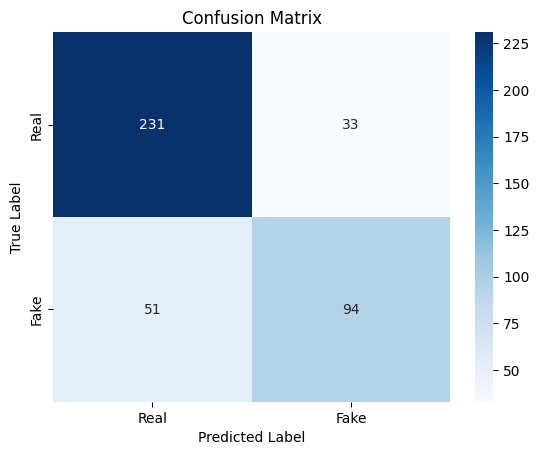

In [40]:
from sklearn.metrics import confusion_matrix
import seaborn as snsb

conf_matrix = confusion_matrix(y_test, predictions)
snsb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### Visualising top 10 fake news site

In [41]:
import seaborn as snsb
from seaborn import barplot

Index(['site_url', 'count'], dtype='object')


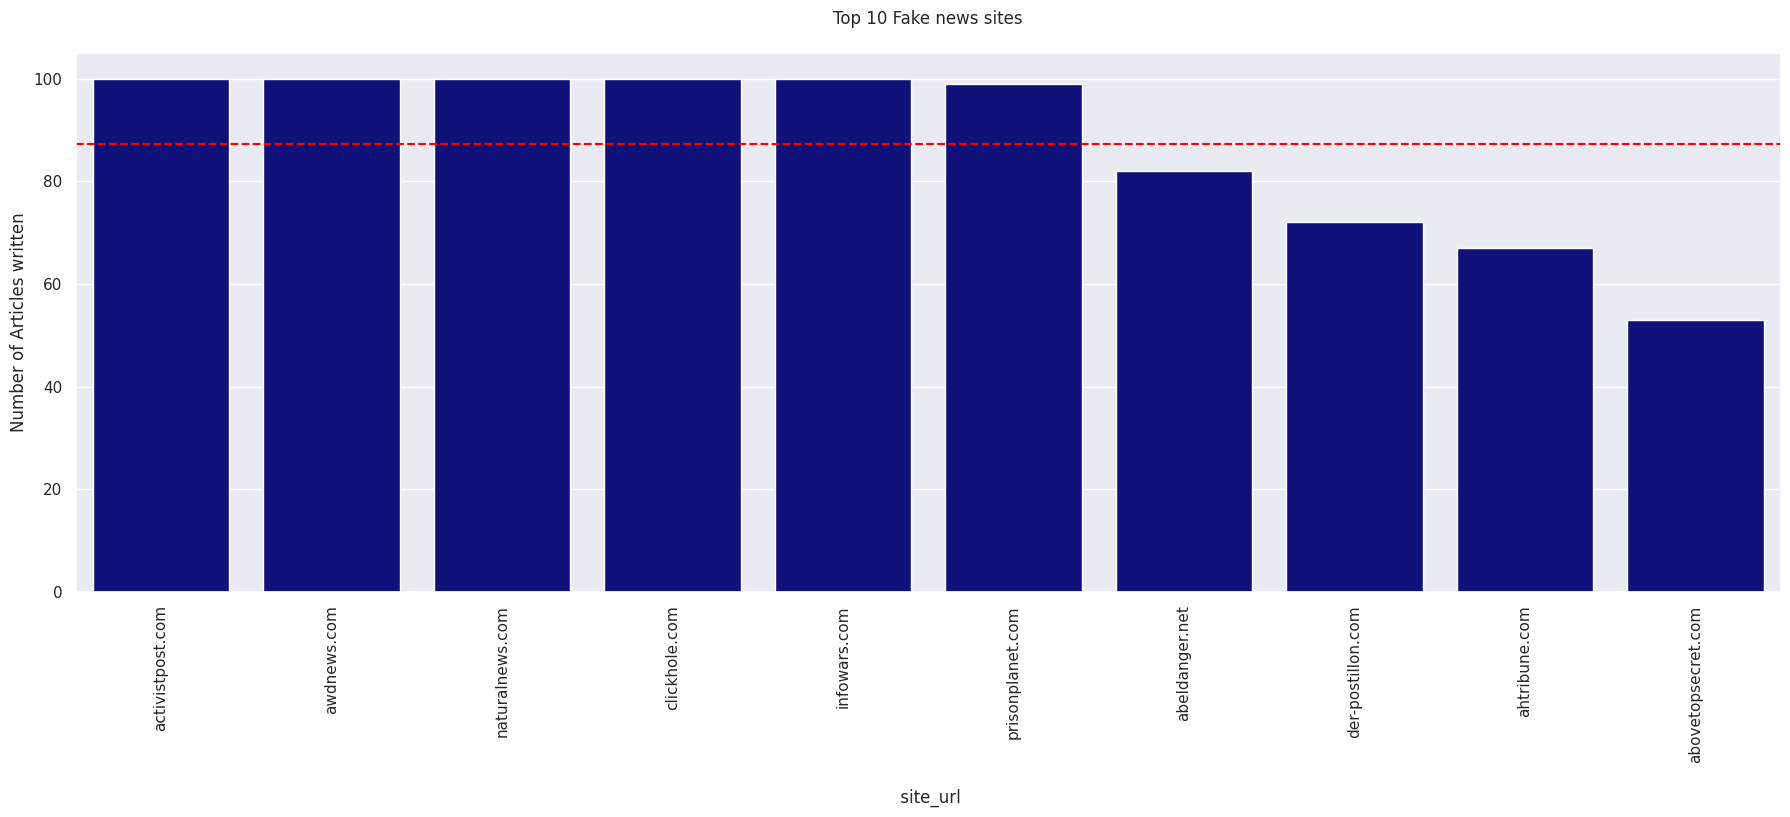

In [42]:
d = df[df['label'] == 'Fake']['site_url'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() # dataframe with top 10 fake news site

# Let's check the column names of dataframe d
print(d.columns)

# Plotting
snsb.set()
plt.figure(figsize=(22,7))
snsb.barplot(x=d.columns[0], y=d.columns[1], data=d, color='darkblue')
plt.xlabel("\n site_url")
plt.ylabel("Number of Articles written")
plt.title("Top 10 Fake news sites\n")
plt.xticks(rotation=90)
plt.axhline(d[d.columns[1]].mean(), color='red', linestyle='--')
plt.show()

### Visualising top 10 trusted sites

Index(['site_url', 'count'], dtype='object')


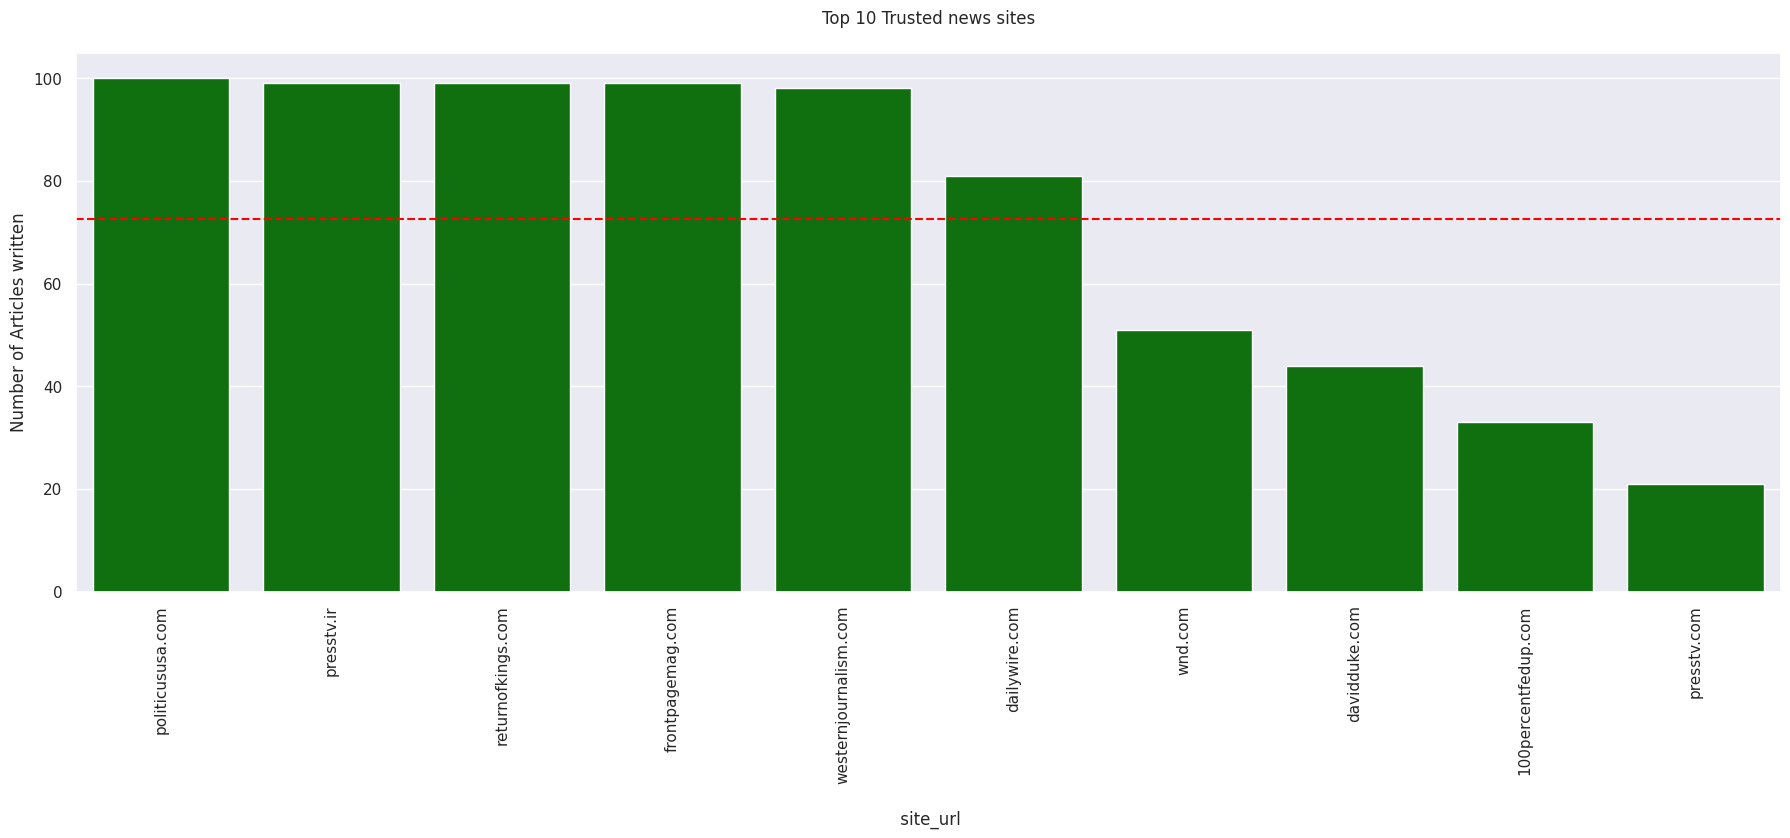

In [43]:
d = df[df['label'] == 'Real']['site_url'].value_counts().sort_values(ascending=False).head(10)
d = pd.DataFrame(d)
d = d.reset_index() 

# Let's check the column names of dataframe d
print(d.columns)

# Plotting
snsb.set()
plt.figure(figsize=(22,7))
snsb.barplot(x=d.columns[0], y=d.columns[1], data=d, color='green')
plt.xlabel("\n site_url")
plt.ylabel("Number of Articles written")
plt.title("Top 10 Trusted news sites\n")
plt.xticks(rotation=90)
plt.axhline(d[d.columns[1]].mean(), color='red', linestyle='--')
plt.show()

In [44]:
df_sources = df[['site_url','label','main_img_url']]
df_r = df_sources.loc[df['label']== 'Real'].iloc[6:10,:]
df_f = df_sources.loc[df['label']== 'Fake'].head(6)

In [45]:
!pip install IPython

In [46]:
def convert(path):
    return '<img src="'+ path + '" width="80">'

In [47]:
from IPython.core.display import HTML
HTML(df_r.to_html(escape=False,formatters=dict(main_img_url=convert)))

,site_url,label,main_img_url
6,100percentfedup.com,Real,
7,100percentfedup.com,Real,
8,100percentfedup.com,Real,
9,100percentfedup.com,Real,


In [48]:
HTML(df_f.to_html(escape=False,formatters=dict(main_img_url=convert)))

,site_url,label,main_img_url
33,21stcenturywire.com,Fake,
34,21stcenturywire.com,Fake,
35,21stcenturywire.com,Fake,
36,21stcenturywire.com,Fake,
37,21stcenturywire.com,Fake,
38,21stcenturywire.com,Fake,


In [49]:
df['site_url'].unique()

array(['100percentfedup.com', '21stcenturywire.com', 'abcnews.com.co',
       'abeldanger.net', 'abovetopsecret.com', 'activistpost.com',
       'addictinginfo.org', 'adobochronicles.com', 'ahtribune.com',
       'allnewspipeline.com', 'americannews.com',
       'americasfreedomfighters.com', 'amren.com', 'amtvmedia.com',
       'awdnews.com', 'barenakedislam.com', 'clickhole.com',
       'coasttocoastam.com', 'corbettreport.com', 'countercurrents.org',
       'counterpunch.org', 'dailywire.com', 'darkmoon.me',
       'davidduke.com', 'davidstockmanscontracorner.com',
       'davidwolfe.com', 'dcclothesline.com', 'defenddemocracy.press',
       'dennismichaellynch.com', 'departed.co', 'der-postillon.com',
       'fromthetrenchesworldreport.com', 'frontpagemag.com',
       'galacticconnection.com', 'globalresearch.ca', 'infowars.com',
       'intrepidreport.com', 'legorafi.fr', 'madworldnews.com',
       'naturalnews.com', 'newstarget.com', 'politicususa.com',
       'presstv.com', 'pre

In [50]:
def plot_bar(df, feat_x, feat_y, normalize=True):
    """ Plot with vertical bars of the requested dataframe and features"""
    
    ct = pd.crosstab(df[feat_x], df[feat_y])
    if normalize == True:
        ct = ct.div(ct.sum(axis=1), axis=0)
    return ct.plot(kind='bar', stacked=True)

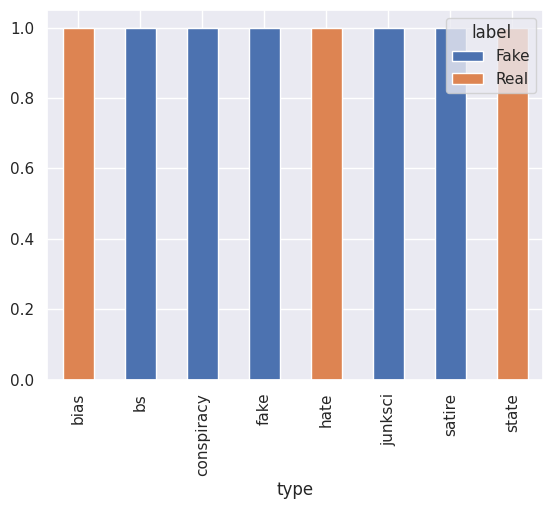

In [51]:
plot_bar(df,'type' , 'label')
plt.show()

####  Checking accuracy

In [52]:
Adab = AdaBoostClassifier(DecisionTreeClassifier(max_depth=10),n_estimators=5,random_state=1)
Adab.fit(X_train_tfidf, y_train)
y_pred3 = Adab.predict(X_test_tfidf)
ABscore = metrics.accuracy_score(y_test,y_pred3)
print("accuracy: %0.3f" %ABscore)

accuracy: 0.751


In [53]:
Rando = RandomForestClassifier(n_estimators=100,random_state=0)
Rando.fit(X_train_tfidf,y_train)
y_pred1 = Rando.predict(X_test_tfidf)
RFscore = metrics.accuracy_score(y_test,y_pred1)
print("accuracy:  %0.3f" %RFscore)

accuracy:  0.782
